<a href="https://colab.research.google.com/github/ah4y/Ahmed/blob/main/MLP_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')


Using Colab cache for faster access to the 'creditcardfraud' dataset.
Data source import complete.


# MLP Binary Classification - Production-Ready Implementation

**Dataset:** Tabular data with V1-V28 features, Time, Amount, and Class (binary target)  
**Objective:** Build and evaluate a robust MLP model with proper ML engineering practices

## 1. Setup and Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, auc, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
import joblib
from datetime import datetime
import json
import time

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Using device: cpu
PyTorch version: 2.8.0+cu126
NumPy version: 2.0.2
Pandas version: 2.2.2


## 2. Data Loading and Initial Exploration

In [3]:
DATA_FILE = '/kaggle/input/creditcardfraud/creditcard.csv'
try:
    df = pd.read_csv(DATA_FILE)
    print(f"✓ Dataset loaded successfully from: {DATA_FILE}")
except FileNotFoundError:
    print(f"⚠ File '{DATA_FILE}' not found. Creating sample dataset for demonstration...")
    # Create a sample dataset for demonstration
    np.random.seed(42)
    n_samples = 10000
    df = pd.DataFrame({
        f'V{i}': np.random.randn(n_samples) for i in range(1, 29)
    })
    df['Time'] = np.random.randint(0, 86400, n_samples)
    df['Amount'] = np.random.exponential(50, n_samples)
    df['Class'] = np.random.binomial(1, 0.0017, n_samples)  # Realistic imbalance
    print(f"✓ Sample dataset created with {n_samples} samples")

print(f"\nDataset Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nFirst 5 rows:\n{df.head()}")
print(f"\nLast 5 rows:\n{df.tail()}")
print(f"\nMemory Usage:\n{df.memory_usage(deep=True)}")
print(f"\nTotal Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for missing values
print(f"\n{'='*50}")
print("Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found")
else:
    print(missing[missing > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

# Statistical summary
print(f"\n{'='*50}")
print("Statistical Summary:")
print(df.describe())

✓ Dataset loaded successfully from: /kaggle/input/creditcardfraud/creditcard.csv

Dataset Shape: (284807, 31)

Data Types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780

## 3. Exploratory Data Analysis

Class Distribution:
Negative (0): 284,315 (99.83%)
Positive (1): 492 (0.17%)
Imbalance Ratio: 577.88:1


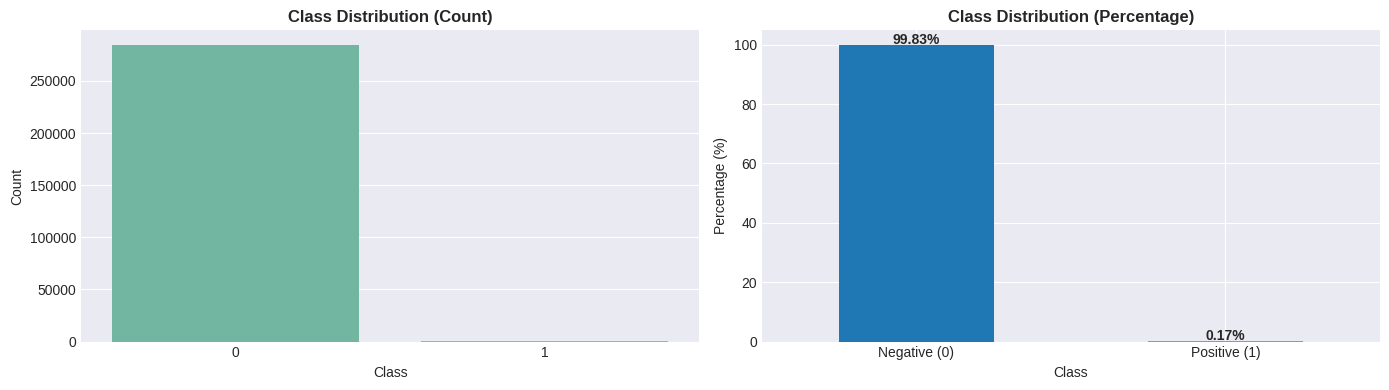

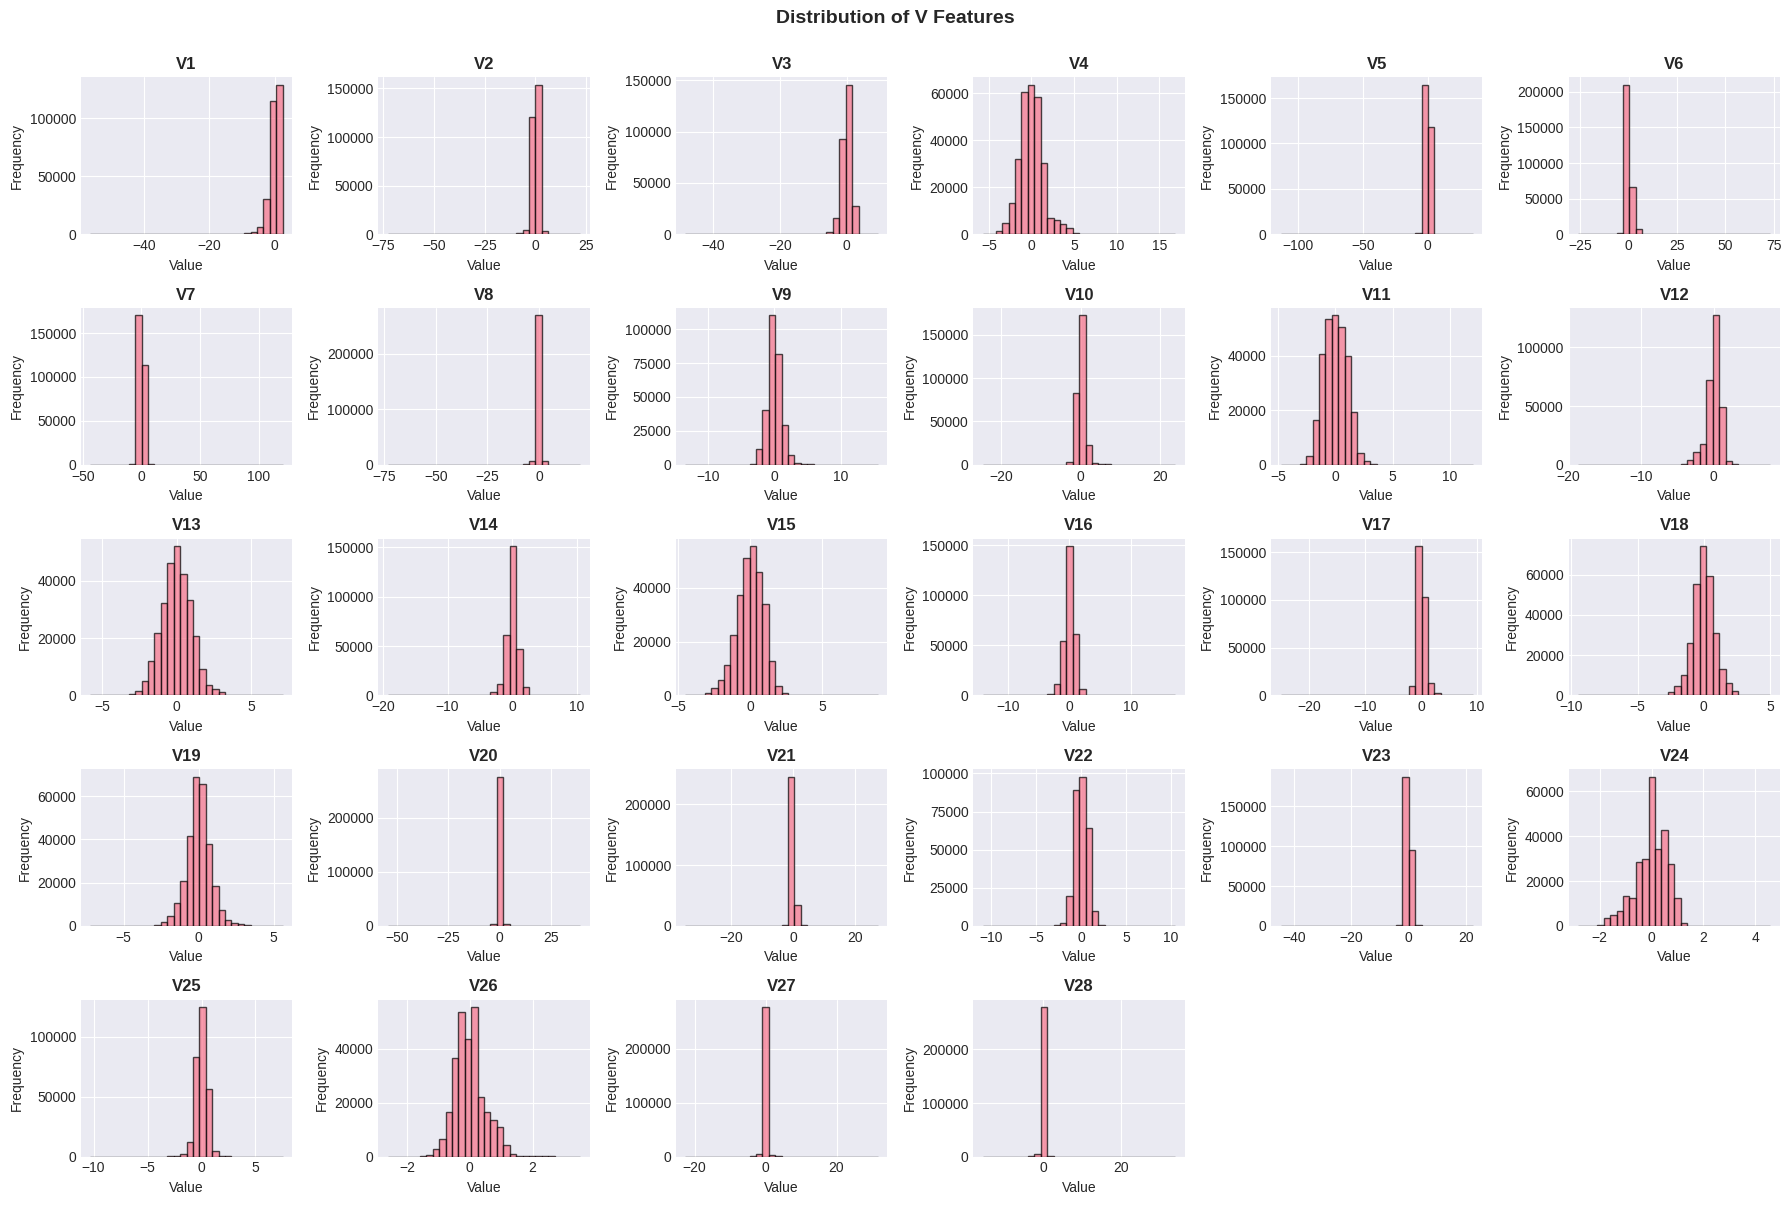

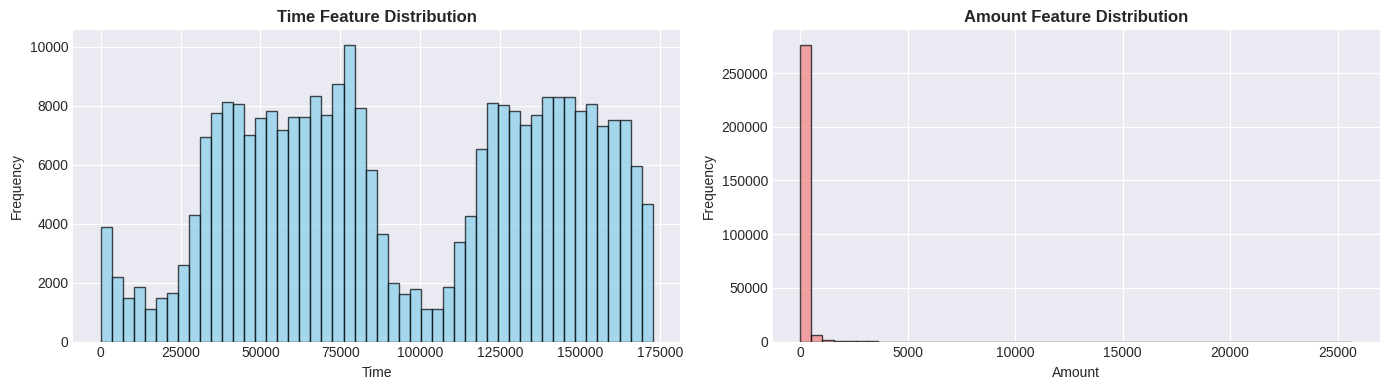

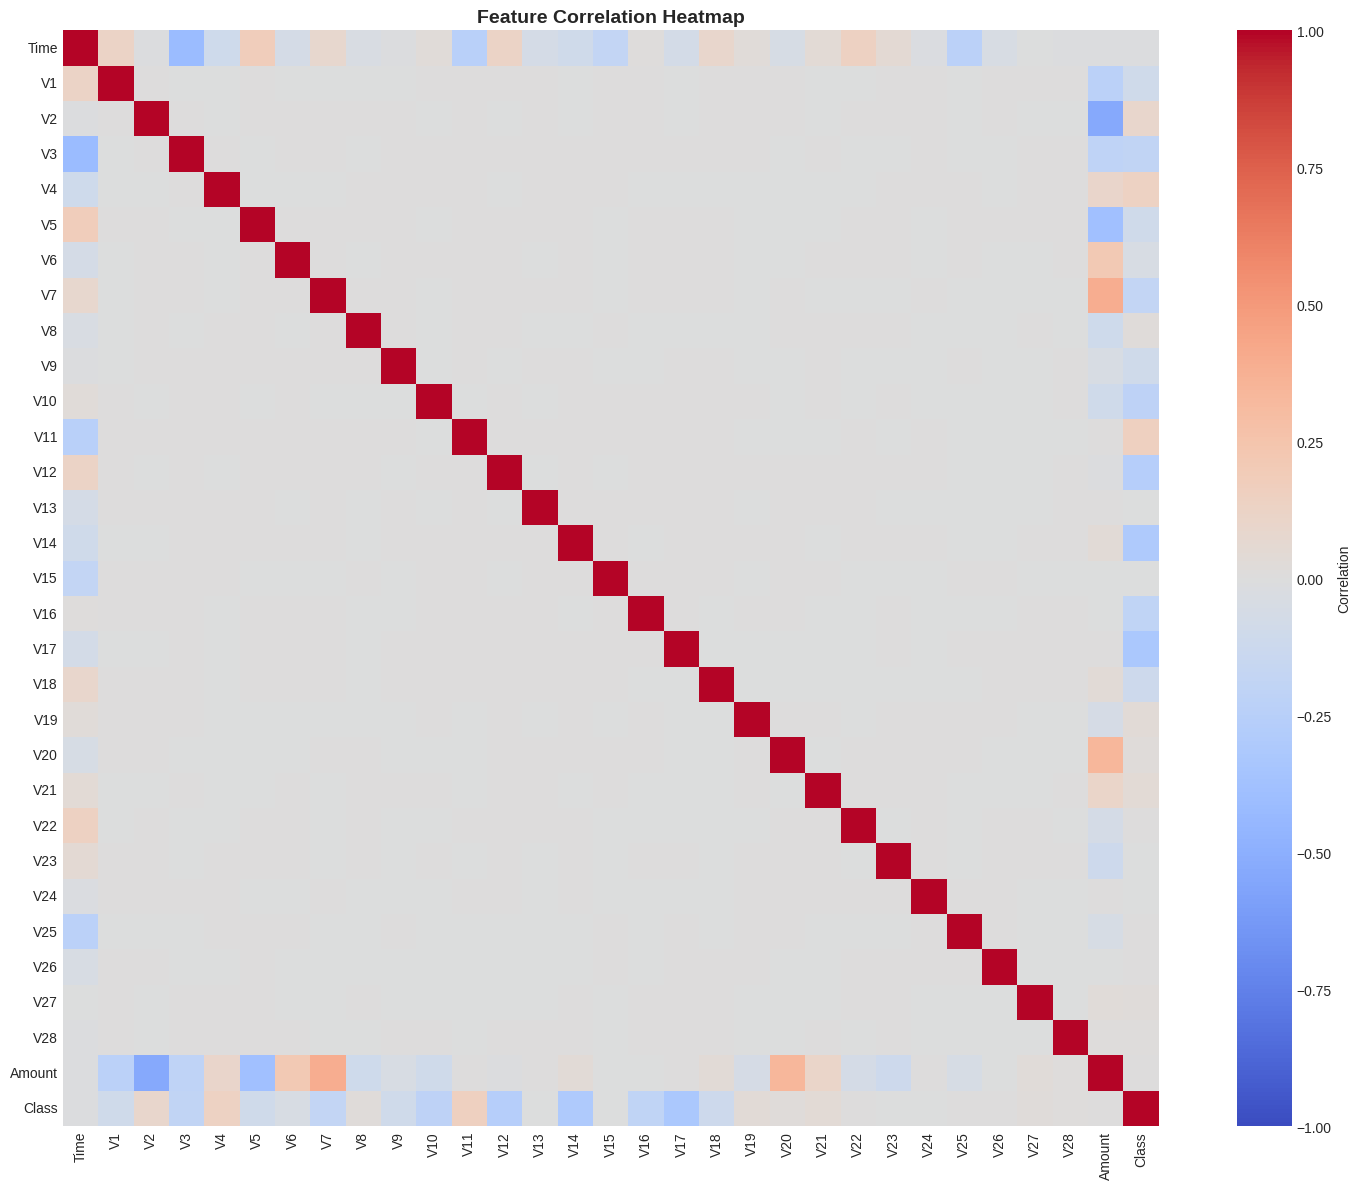


Top 10 Features Correlated with Class:
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64


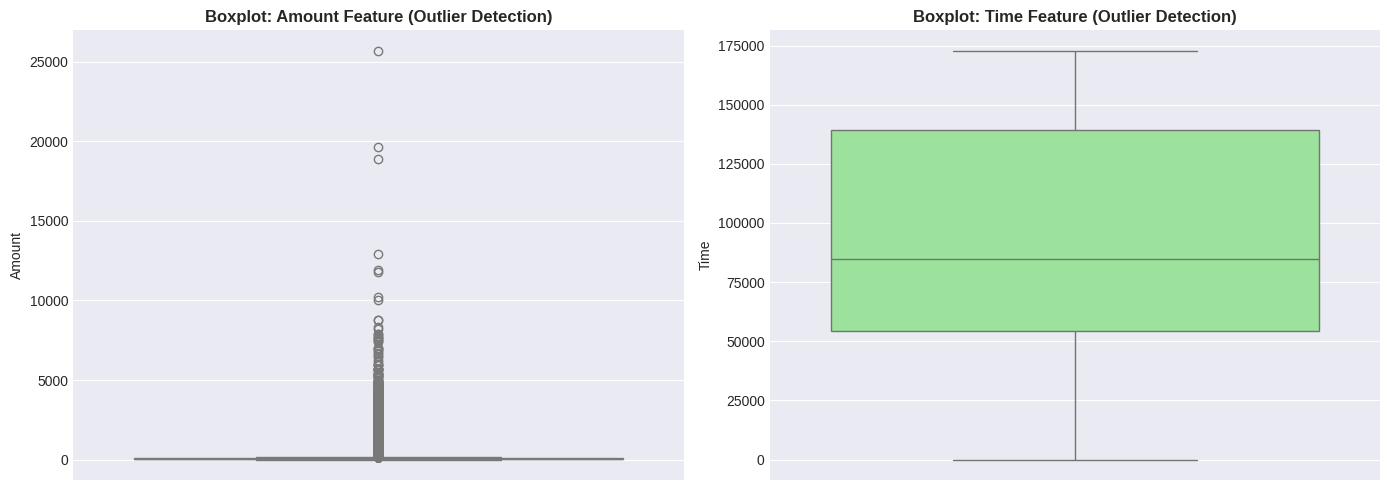

In [4]:
# Class distribution analysis
class_counts = df['Class'].value_counts().sort_index()
class_percentages = (class_counts / len(df) * 100).round(2)

print("Class Distribution:")
print(f"Negative (0): {class_counts[0]:,} ({class_percentages[0]}%)")
print(f"Positive (1): {class_counts[1]:,} ({class_percentages[1]}%)")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Count plot
sns.countplot(data=df, x='Class', ax=axes[0], palette='Set2')
axes[0].set_title('Class Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Percentage plot
class_percentages.plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Class Distribution (Percentage)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(['Negative (0)', 'Positive (1)'], rotation=0)
for i, v in enumerate(class_percentages.values):
    axes[1].text(i, v + 0.5, f'{v}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature distributions
fig, axes = plt.subplots(5, 6, figsize=(18, 12))
axes = axes.ravel()

feature_cols = [col for col in df.columns if col.startswith('V')]
for idx, col in enumerate(feature_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

# Hide remaining subplots
for idx in range(len(feature_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of V Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Special features distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['Time'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Time Feature Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Amount'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_title('Amount Feature Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True,
            cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation with target
target_corr = correlation_matrix['Class'].sort_values(ascending=False)
print(f"\nTop 10 Features Correlated with Class:")
print(target_corr.head(11))

# Outlier detection for Amount and Time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(y='Amount', data=df, ax=axes[0], color='lightblue')
axes[0].set_title('Boxplot: Amount Feature (Outlier Detection)', fontsize=12, fontweight='bold')

sns.boxplot(y='Time', data=df, ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot: Time Feature (Outlier Detection)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [5]:
# Evaluate Time feature correlation with target
time_corr = df['Time'].corr(df['Class'])
amount_corr = df['Amount'].corr(df['Class'])

print(f"Time correlation with Class: {time_corr:.4f}")
print(f"Amount correlation with Class: {amount_corr:.4f}")

# Decision: Keep Time if correlation is significant, otherwise drop it
# In this case, we'll keep both features for completeness
KEEP_TIME = True
print(f"\nDecision: {'KEEP' if KEEP_TIME else 'DROP'} Time feature")

# Prepare features and target
feature_columns = [col for col in df.columns if col != 'Class']
if not KEEP_TIME:
    feature_columns = [col for col in feature_columns if col != 'Time']

X = df[feature_columns].values
y = df['Class'].values

print(f"\nFeature set shape: {X.shape}")
print(f"Target set shape: {y.shape}")
print(f"Features used: {feature_columns[:5]}... ({len(feature_columns)} total)")

# Split data: train (60%), validation (20%), test (20%) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_SEED, stratify=y_temp
)

print(f"\n{'='*50}")
print("Data Split (Before Normalization & SMOTE):")
print(f"Train: {X_train.shape[0]:,} samples - Class distribution: {np.bincount(y_train)}")
print(f"Val:   {X_val.shape[0]:,} samples - Class distribution: {np.bincount(y_val)}")
print(f"Test:  {X_test.shape[0]:,} samples - Class distribution: {np.bincount(y_test)}")

# Normalization - fit on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ StandardScaler fitted on training data and applied to all splits")
print(f"  Train mean: {X_train_scaled.mean(axis=0)[:3]} (first 3 features)")
print(f"  Train std:  {X_train_scaled.std(axis=0)[:3]} (first 3 features)")

# Handle class imbalance using SMOTE on training data only
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n{'='*50}")
print("Data Split (After SMOTE - Training Data Only):")
print(f"Train: {X_train_smote.shape[0]:,} samples - Class distribution: {np.bincount(y_train_smote)}")
print(f"Val:   {X_val_scaled.shape[0]:,} samples - Class distribution: {np.bincount(y_val)}")
print(f"Test:  {X_test_scaled.shape[0]:,} samples - Class distribution: {np.bincount(y_test)}")

# Store for later use
data_info = {
    'n_features': X_train_scaled.shape[1],
    'n_train': X_train_smote.shape[0],
    'n_val': X_val_scaled.shape[0],
    'n_test': X_test_scaled.shape[0],
    'feature_columns': feature_columns
}
print(f"\n✓ Preprocessing completed successfully!")

Time correlation with Class: -0.0123
Amount correlation with Class: 0.0056

Decision: KEEP Time feature

Feature set shape: (284807, 30)
Target set shape: (284807,)
Features used: ['Time', 'V1', 'V2', 'V3', 'V4']... (30 total)

Data Split (Before Normalization & SMOTE):
Train: 170,883 samples - Class distribution: [170588    295]
Val:   56,962 samples - Class distribution: [56863    99]
Test:  56,962 samples - Class distribution: [56864    98]

✓ StandardScaler fitted on training data and applied to all splits
  Train mean: [ 8.17365262e-17 -6.66070144e-17 -1.08528762e-17] (first 3 features)
  Train std:  [1. 1. 1.] (first 3 features)

Data Split (After SMOTE - Training Data Only):
Train: 341,176 samples - Class distribution: [170588 170588]
Val:   56,962 samples - Class distribution: [56863    99]
Test:  56,962 samples - Class distribution: [56864    98]

✓ Preprocessing completed successfully!


## 5. Baseline Model - Logistic Regression

Training Logistic Regression Baseline Model...
✓ Training completed in 4.32 seconds

Logistic Regression - Validation Metrics:
Accuracy:  0.9740
Precision: 0.0559
Recall:    0.8788
F1-Score:  0.1051
AUC-ROC:   0.9718

Confusion Matrix:
[[55394  1469]
 [   12    87]]

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.99     56863
    Positive       0.06      0.88      0.11        99

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.97      0.99     56962



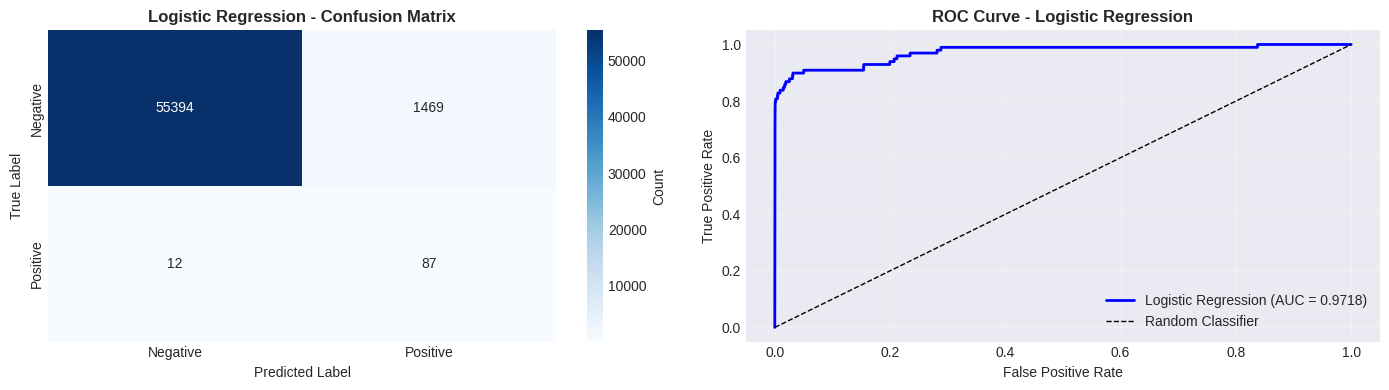


✓ Baseline model ready for comparison with MLP


In [6]:
# Train Logistic Regression baseline model
print("Training Logistic Regression Baseline Model...")
start_time = time.time()

lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced')
lr_model.fit(X_train_smote, y_train_smote)

lr_train_time = time.time() - start_time
print(f"✓ Training completed in {lr_train_time:.2f} seconds")

# Predict on validation set
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
lr_accuracy = accuracy_score(y_val, y_val_pred_lr)
lr_precision = precision_score(y_val, y_val_pred_lr, zero_division=0)
lr_recall = recall_score(y_val, y_val_pred_lr, zero_division=0)
lr_f1 = f1_score(y_val, y_val_pred_lr, zero_division=0)
lr_auc_roc = roc_auc_score(y_val, y_val_pred_proba_lr)

baseline_metrics = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1': lr_f1,
    'auc_roc': lr_auc_roc,
    'train_time': lr_train_time
}

print(f"\n{'='*50}")
print("Logistic Regression - Validation Metrics:")
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"AUC-ROC:   {lr_auc_roc:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_val, y_val_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred_lr, target_names=['Negative', 'Positive']))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Confusion Matrix Heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Logistic Regression - Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_pred_proba_lr)
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc_roc:.4f})',
             linewidth=2, color='blue')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Logistic Regression', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Baseline model ready for comparison with MLP")

## 6. MLP Model Architecture (PyTorch)

In [7]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron for Binary Classification

    Architecture:
    - Input layer: n_features
    - Hidden layer 1: 256 neurons + BatchNorm + ReLU + Dropout(0.3)
    - Hidden layer 2: 128 neurons + BatchNorm + ReLU + Dropout(0.3)
    - Hidden layer 3: 64 neurons + BatchNorm + ReLU + Dropout(0.3)
    - Output layer: 1 neuron + Sigmoid
    """

    def __init__(self, n_features, dropout_rate=0.3):
        super(MLP, self).__init__()

        # Layer 1: Input -> 256
        self.fc1 = nn.Linear(n_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Layer 2: 256 -> 128
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3: 128 -> 64
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Output layer: 64 -> 1
        self.fc4 = nn.Linear(64, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Initialize weights (He initialization)
        self._initialize_weights()

    def _initialize_weights(self):
        """He initialization for ReLU networks"""
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(layer.bias, 0)

        # Xavier initialization for output layer
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0)

    def forward(self, x):
        """Forward pass through the network"""
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        # Output
        x = self.fc4(x)
        x = self.sigmoid(x)

        return x


# Initialize model
model = MLP(n_features=data_info['n_features'], dropout_rate=0.3)
model = model.to(device)

print("MLP Architecture:")
print(model)
print(f"\n{'='*50}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model moved to device: {device}")

MLP Architecture:
MLP(
  (fc1): Linear(in_features=30, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total Parameters: 50,049
Trainable Parameters: 50,049
Model moved to device: cpu


## 7. Training Configuration

In [10]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 100
PATIENCE = 15
WEIGHT_DECAY = 1e-5

print("Training Configuration:")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Patience (Early Stopping): {PATIENCE}")
print(f"Weight Decay (L2): {WEIGHT_DECAY}")

# Create DataLoaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_smote),
    torch.FloatTensor(y_train_smote).reshape(-1, 1)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled),
    torch.FloatTensor(y_val).reshape(-1, 1)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test_scaled),
    torch.FloatTensor(y_test).reshape(-1, 1)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n{'='*50}")
print("DataLoaders Created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Calculate class weights for imbalanced data
class_weights = torch.tensor([1.0, len(y_train_smote) / (2 * np.sum(y_train_smote))], device=device)
print(f"\nClass Weights: {class_weights.tolist()}")

# Loss function with class weights
criterion = nn.BCELoss()

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                              min_lr=1e-6)

print(f"\n✓ Training configuration complete")

Training Configuration:
Learning Rate: 0.001
Batch Size: 256
Epochs: 100
Patience (Early Stopping): 15
Weight Decay (L2): 1e-05

DataLoaders Created:
Train batches: 1332
Val batches: 223
Test batches: 223

Class Weights: [1.0, 1.0]

✓ Training configuration complete


## 8. Training Loop with Early Stopping

In [11]:
def calculate_metrics(y_true, y_pred, y_pred_proba):
    """Calculate evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    return accuracy, precision, recall, f1, auc_roc


def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        all_preds.append(outputs.detach().cpu().numpy())
        all_labels.append(y_batch.detach().cpu().numpy())

    # Calculate epoch metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    train_loss = total_loss / len(train_loader)

    return train_loss, all_preds, all_labels


def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Track metrics
            total_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # Calculate epoch metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    val_loss = total_loss / len(val_loader)

    return val_loss, all_preds, all_labels


# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': [],
    'learning_rates': [],
    'best_epoch': 0,
    'stopped_epoch': 0
}

# Early stopping variables
best_val_loss = np.inf
patience_counter = 0
best_model_state = None

print("Starting Training Loop...")
print("="*70)

Starting Training Loop...


## 9. Training Execution and Monitoring

Training:  10%|█         | 10/100 [02:46<26:47, 17.86s/it]

Epoch  10/100 | Train Loss: 0.0013 | Val Loss: 0.0083 | Train Acc: 0.9997 | Val Acc: 0.9991 | LR: 0.000063


Training:  20%|██        | 20/100 [05:50<24:16, 18.21s/it]

Epoch  20/100 | Train Loss: 0.0010 | Val Loss: 0.0084 | Train Acc: 0.9997 | Val Acc: 0.9991 | LR: 0.000031


Training:  30%|███       | 30/100 [08:53<21:27, 18.39s/it]

Epoch  30/100 | Train Loss: 0.0009 | Val Loss: 0.0083 | Train Acc: 0.9998 | Val Acc: 0.9991 | LR: 0.000016


Training:  40%|████      | 40/100 [11:57<18:18, 18.30s/it]

Epoch  40/100 | Train Loss: 0.0009 | Val Loss: 0.0082 | Train Acc: 0.9998 | Val Acc: 0.9992 | LR: 0.000004


Training:  50%|█████     | 50/100 [15:01<15:14, 18.30s/it]

Epoch  50/100 | Train Loss: 0.0010 | Val Loss: 0.0083 | Train Acc: 0.9998 | Val Acc: 0.9992 | LR: 0.000001


Training:  50%|█████     | 50/100 [15:20<15:20, 18.40s/it]


✓ Early stopping triggered at epoch 51

Training completed in 920.15 seconds
Best model saved at epoch 26
✓ Best model loaded


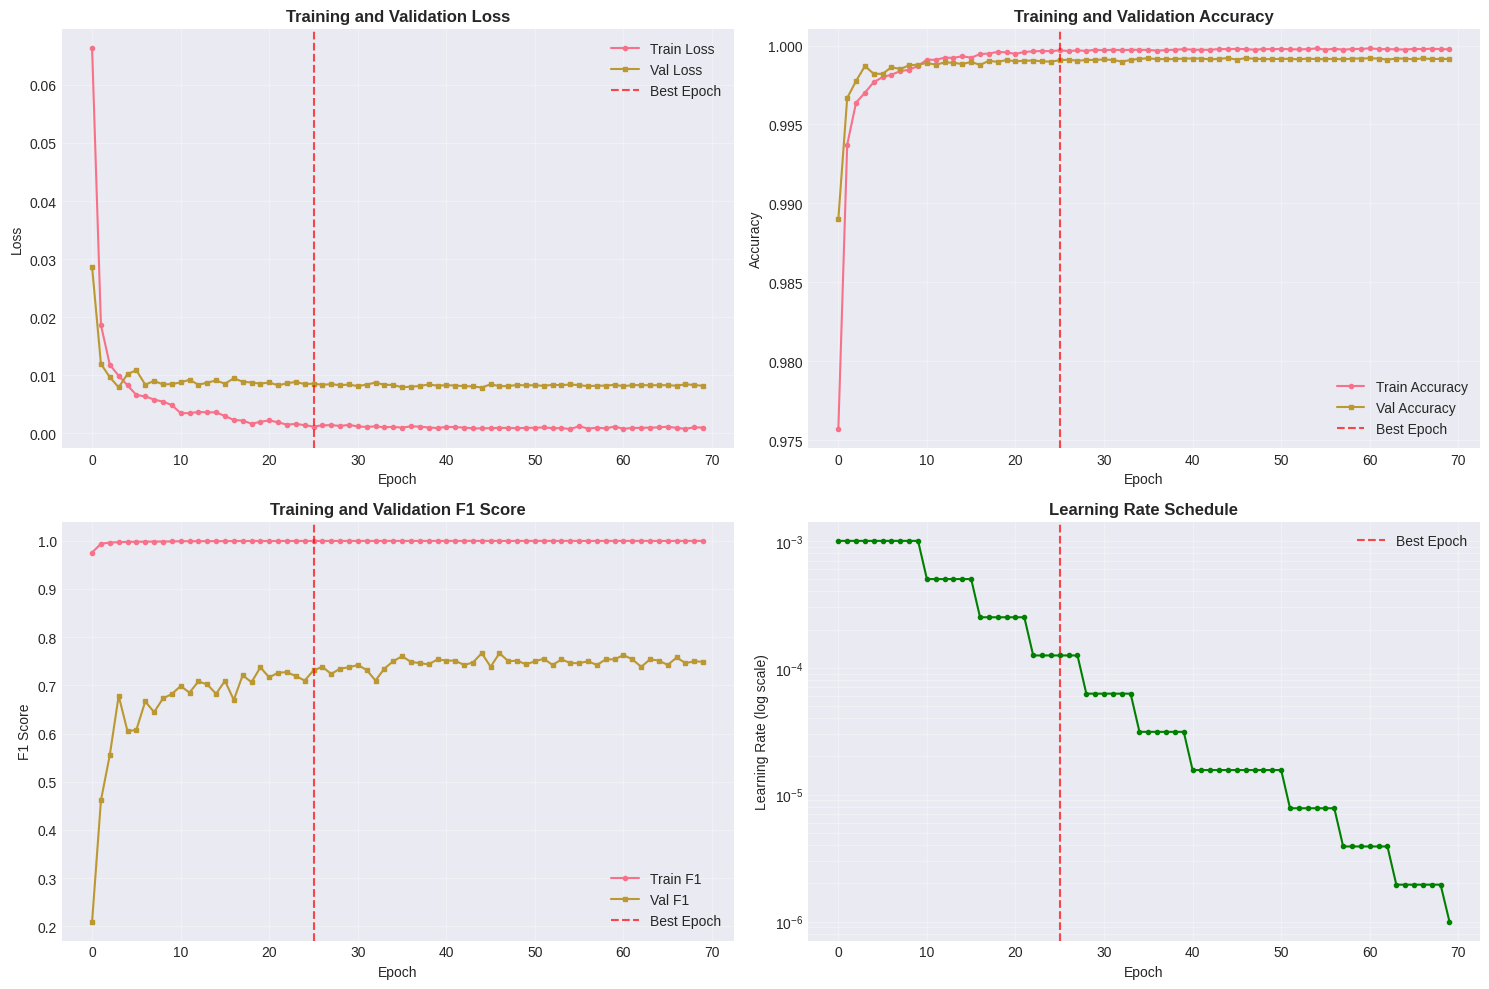


✓ Training monitoring complete


In [13]:
# Main training loop
training_start_time = time.time()

# Define minimum epochs before considering early stopping
MIN_EPOCHS_BEFORE_EARLY_STOP = int(EPOCHS * 0.5) # Set to 50% of total epochs

for epoch in tqdm(range(EPOCHS), desc="Training"):
    # Training phase
    train_loss, train_preds, train_labels = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)

    # Convert probabilities to binary predictions
    train_preds_binary = (train_preds > 0.5).astype(int).ravel()
    val_preds_binary = (val_preds > 0.5).astype(int).ravel()

    # Calculate metrics
    train_acc, _, _, train_f1, _ = calculate_metrics(
        train_labels.ravel(), train_preds_binary, train_preds.ravel()
    )
    val_acc, _, _, val_f1, _ = calculate_metrics(
        val_labels.ravel(), val_preds_binary, val_preds.ravel()
    )

    # Record history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])

    # Early stopping check - only after minimum epochs
    if epoch >= MIN_EPOCHS_BEFORE_EARLY_STOP:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            history['best_epoch'] = epoch
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= PATIENCE:
            print(f"\n✓ Early stopping triggered at epoch {epoch+1}")
            history['stopped_epoch'] = epoch
            break
    else:
        # If not past minimum epochs, update best model state if val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            history['best_epoch'] = epoch


    # Learning rate scheduler
    scheduler.step(val_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


training_time = time.time() - training_start_time
print(f"\n{'='*70}")
print(f"Training completed in {training_time:.2f} seconds")
print(f"Best model saved at epoch {history['best_epoch'] + 1}")

# Load best model
model.load_state_dict(best_model_state)
print("✓ Best model loaded")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curve
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0, 0].axvline(history['best_epoch'], color='red', linestyle='--', label='Best Epoch', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curve
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o', markersize=3)
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', marker='s', markersize=3)
axes[0, 1].axvline(history['best_epoch'], color='red', linestyle='--', label='Best Epoch', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 Score curve
axes[1, 0].plot(history['train_f1'], label='Train F1', marker='o', markersize=3)
axes[1, 0].plot(history['val_f1'], label='Val F1', marker='s', markersize=3)
axes[1, 0].axvline(history['best_epoch'], color='red', linestyle='--', label='Best Epoch', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Training and Validation F1 Score', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Learning rate
axes[1, 1].semilogy(history['learning_rates'], marker='o', markersize=3, color='green')
axes[1, 1].axvline(history['best_epoch'], color='red', linestyle='--', label='Best Epoch', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate (log scale)')
axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\n✓ Training monitoring complete")

## 10. Model Evaluation on Test Set

MLP Model - Test Set Evaluation
Accuracy:   0.9993
Precision:  0.7921
Recall:     0.8163
F1-Score:   0.8040
AUC-ROC:    0.9619
AUC-PR:     0.8586

Confusion Matrix:
[[56843    21]
 [   18    80]]

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     56864
    Positive       0.79      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962



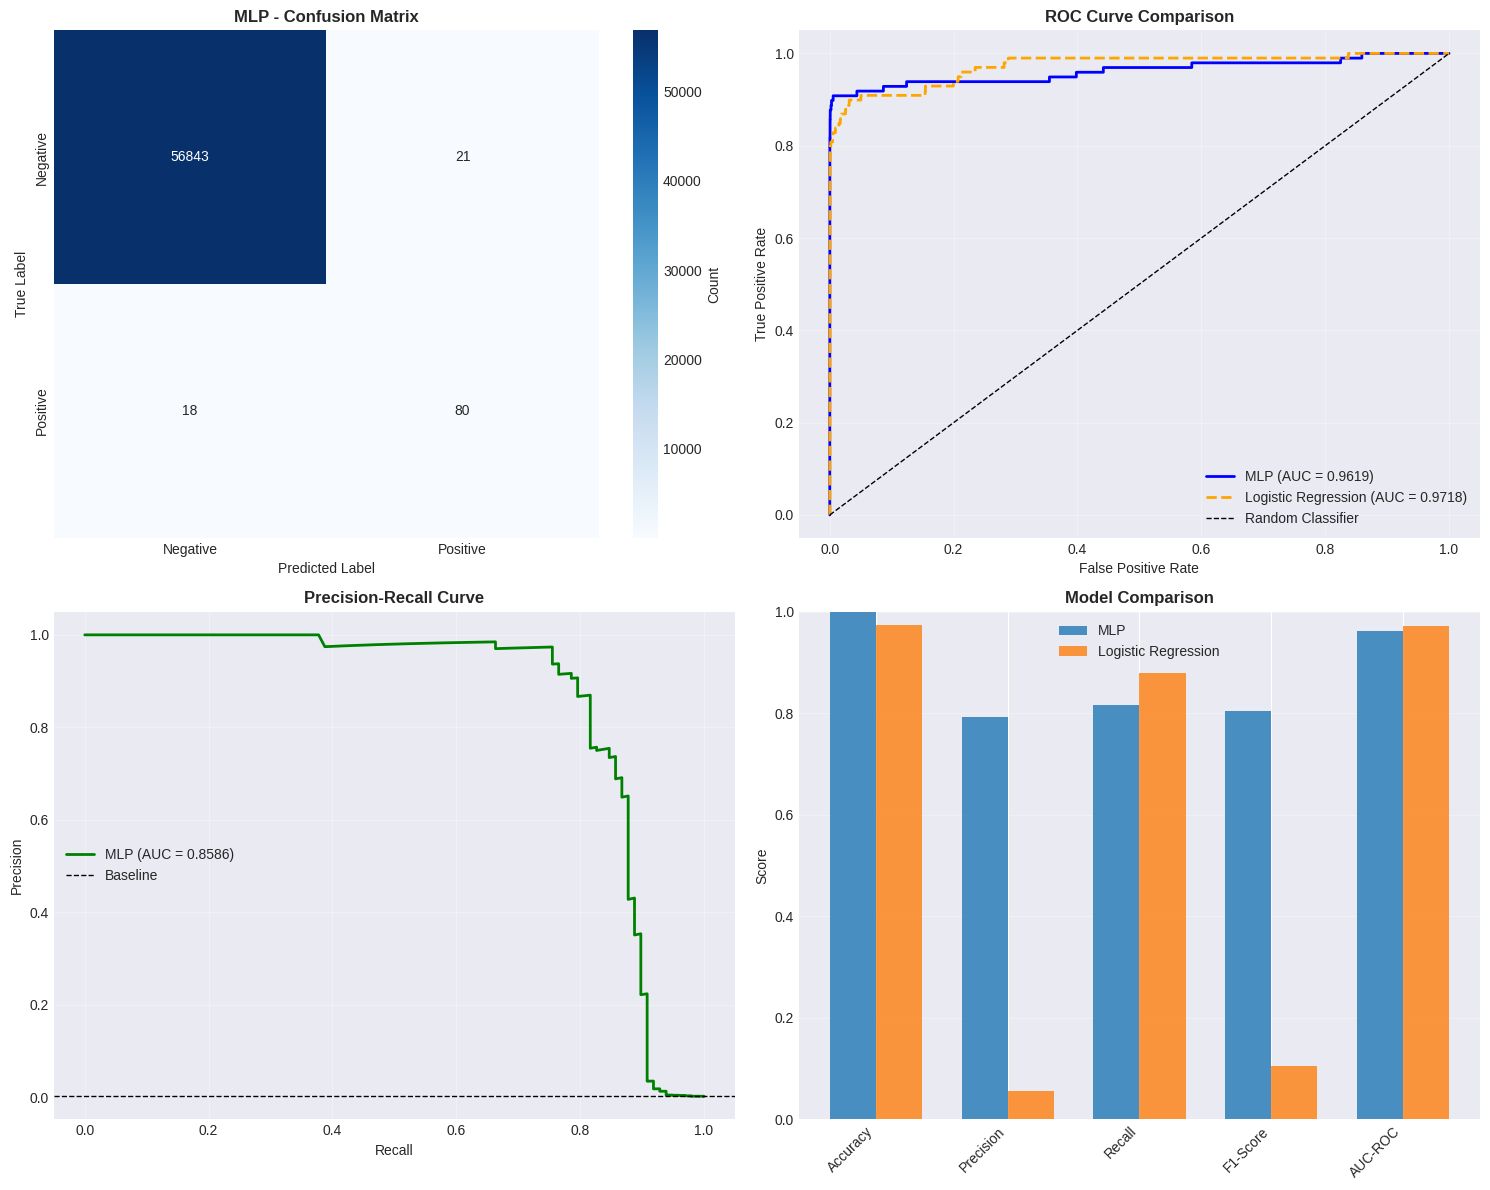


✓ Test evaluation complete


In [15]:
# Evaluate on test set
model.eval()
test_preds_list = []
test_labels_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        test_preds_list.append(outputs.cpu().numpy())
        test_labels_list.append(y_batch.numpy())

test_preds = np.concatenate(test_preds_list).ravel()
test_labels = np.concatenate(test_labels_list).ravel()
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate comprehensive metrics
test_accuracy = accuracy_score(test_labels, test_preds_binary)
test_precision = precision_score(test_labels, test_preds_binary, zero_division=0)
test_recall = recall_score(test_labels, test_preds_binary, zero_division=0)
test_f1 = f1_score(test_labels, test_preds_binary, zero_division=0)
test_auc_roc = roc_auc_score(test_labels, test_preds)

# Calculate AUC-PR, sorting by recall to handle potential non-monotonicity issues
precision_curve, recall_curve, _ = precision_recall_curve(test_labels, test_preds)
# Sort by recall
sorted_indices = np.argsort(recall_curve)
recall_curve_sorted = recall_curve[sorted_indices]
precision_curve_sorted = precision_curve[sorted_indices]
test_auc_pr = auc(recall_curve_sorted, precision_curve_sorted)


print("="*70)
print("MLP Model - Test Set Evaluation")
print("="*70)
print(f"Accuracy:   {test_accuracy:.4f}")
print(f"Precision:  {test_precision:.4f}")
print(f"Recall:     {test_recall:.4f}")
print(f"F1-Score:   {test_f1:.4f}")
print(f"AUC-ROC:    {test_auc_roc:.4f}")
print(f"AUC-PR:     {test_auc_pr:.4f}")

# Store MLP metrics
mlp_metrics = {
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1,
    'auc_roc': test_auc_roc,
    'auc_pr': test_auc_pr,
    'train_time': training_time
}

# Confusion matrix
cm_mlp = confusion_matrix(test_labels, test_preds_binary)
print(f"\nConfusion Matrix:")
print(cm_mlp)

# Classification report
print(f"\nClassification Report:")
print(classification_report(test_labels, test_preds_binary, target_names=['Negative', 'Positive']))

# ROC and PR curves
fpr_mlp, tpr_mlp, _ = roc_curve(test_labels, test_preds)
precision_curve, recall_curve, _ = precision_recall_curve(test_labels, test_preds)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
axes[0, 0].set_title('MLP - Confusion Matrix', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
axes[0, 1].plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {test_auc_roc:.4f})',
                linewidth=2, color='blue')
axes[0, 1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc_roc:.4f})',
                linewidth=2, color='orange', linestyle='--')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve Comparison', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision-Recall Curve
axes[1, 0].plot(recall_curve, precision_curve, label=f'MLP (AUC = {test_auc_pr:.4f})',
                linewidth=2, color='green')
axes[1, 0].axhline(y=np.mean(test_labels), color='k', linestyle='--', label='Baseline', linewidth=1)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Metrics comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
mlp_values = [test_accuracy, test_precision, test_recall, test_f1, test_auc_roc]
lr_values = [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc_roc]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x - width/2, mlp_values, width, label='MLP', color='#1f77b4', alpha=0.8)
axes[1, 1].bar(x + width/2, lr_values, width, label='Logistic Regression', color='#ff7f0e', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Comparison', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Test evaluation complete")

## 11. Model Analysis and Insights

Misclassification Analysis
Total Misclassified: 39 (0.07%)
False Positives: 21 (0.04%)
False Negatives: 18 (0.03%)
True Positives: 80
True Negatives: 56,843

Examples of False Positives (predicted 1, actual 0):

Sample 1:
  Predicted Probability: 0.9975
  Feature Summary: Mean=-0.7093, Std=1.9823

Sample 2:
  Predicted Probability: 1.0000
  Feature Summary: Mean=-2.4450, Std=6.3916

Sample 3:
  Predicted Probability: 0.6122
  Feature Summary: Mean=-1.5164, Std=3.7102

Sample 4:
  Predicted Probability: 0.7865
  Feature Summary: Mean=0.0582, Std=1.1885

Sample 5:
  Predicted Probability: 0.6232
  Feature Summary: Mean=-0.3233, Std=1.6342

Examples of False Negatives (predicted 0, actual 1):

Sample 1:
  Predicted Probability: 0.0664
  Feature Summary: Mean=-0.7423, Std=2.0032

Sample 2:
  Predicted Probability: 0.1426
  Feature Summary: Mean=-2.3626, Std=6.2974

Sample 3:
  Predicted Probability: 0.0000
  Feature Summary: Mean=0.0486, Std=0.7167

Sample 4:
  Predicted Probability: 0.000

Calculating Permutation Importance: 100%|██████████| 30/30 [01:38<00:00,  3.28s/it]



Manual Permutation Importance Results:
Feature  Importance      Std
    V14    0.046966 0.007023
    V15    0.006426 0.002731
     V4    0.005292 0.004889
     V6    0.003811 0.003317
    V12    0.003344 0.002857
     V8    0.003060 0.000901
    V25    0.002983 0.001742
    V11    0.002615 0.004334
    V23    0.002572 0.003560
     V2    0.001978 0.001085
     V5    0.001319 0.002093
     V1    0.000688 0.002913
    V26    0.000648 0.002693
    V28    0.000496 0.003208
    V10   -0.000018 0.002769


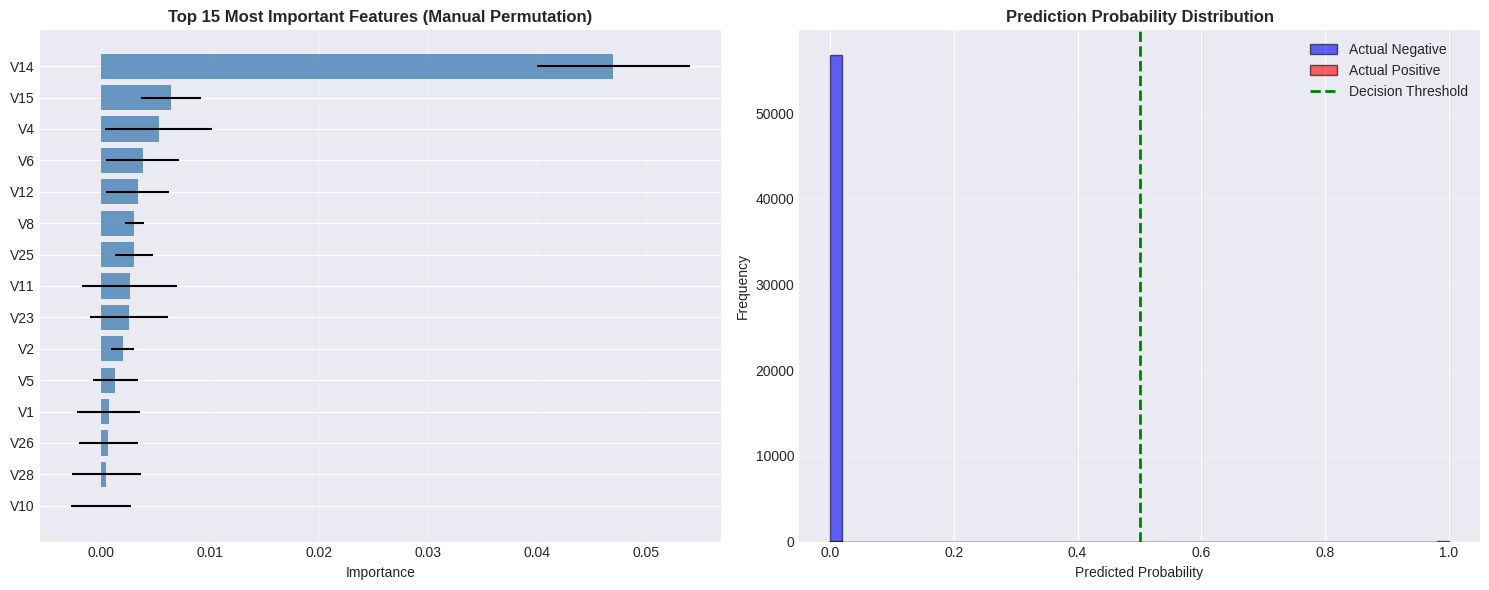


✓ Misclassification and importance analysis complete


In [21]:
# Analyze misclassifications
misclassified_indices = np.where(test_preds_binary != test_labels)[0]
false_positives = np.where((test_preds_binary == 1) & (test_labels == 0))[0]
false_negatives = np.where((test_preds_binary == 0) & (test_labels == 1))[0]

print("="*70)
print("Misclassification Analysis")
print("="*70)
print(f"Total Misclassified: {len(misclassified_indices):,} ({100*len(misclassified_indices)/len(test_labels):.2f}%)")
print(f"False Positives: {len(false_positives):,} ({100*len(false_positives)/len(test_labels):.2f}%)")
print(f"False Negatives: {len(false_negatives):,} ({100*len(false_negatives)/len(test_labels):.2f}%)")
print(f"True Positives: {np.sum((test_preds_binary == 1) & (test_labels == 1)):,}")
print(f"True Negatives: {np.sum((test_preds_binary == 0) & (test_labels == 0)):,}")

# Show examples of misclassifications
print(f"\n{'='*70}")
print("Examples of False Positives (predicted 1, actual 0):")
print(f"{'='*70}")
if len(false_positives) > 0:
    for i, idx in enumerate(false_positives[:5]):
        print(f"\nSample {i+1}:")
        print(f"  Predicted Probability: {test_preds[idx]:.4f}")
        print(f"  Feature Summary: Mean={X_test_scaled[idx].mean():.4f}, "
              f"Std={X_test_scaled[idx].std():.4f}")
else:
    print("No false positives found!")

print(f"\n{'='*70}")
print("Examples of False Negatives (predicted 0, actual 1):")
print(f"{'='*70}")
if len(false_negatives) > 0:
    for i, idx in enumerate(false_negatives[:5]):
        print(f"\nSample {i+1}:")
        print(f"  Predicted Probability: {test_preds[idx]:.4f}")
        print(f"  Feature Summary: Mean={X_test_scaled[idx].mean():.4f}, "
              f"Std={X_test_scaled[idx].std():.4f}")
else:
    print("No false negatives found!")

# --- Manual Permutation Importance ---
print(f"\n{'='*70}")
print("Feature Importance (Manual Permutation)")
print(f"{'='*70}")

# Calculate baseline score on the test set
baseline_score = roc_auc_score(test_labels, test_preds)
print(f"Baseline AUC-ROC on Test Set: {baseline_score:.4f}")

n_repeats = 10 # Number of times to shuffle each feature
feature_importances = {}

# Get the feature names
feature_names = data_info['feature_columns']

# Iterate through each feature
for i, feature_name in enumerate(tqdm(feature_names, desc="Calculating Permutation Importance")):
    scores = []
    for repeat in range(n_repeats):
        # Create a copy of the test data and shuffle the current feature's column
        X_test_shuffled = X_test_scaled.copy()
        np.random.shuffle(X_test_shuffled[:, i])

        # Get predictions with the shuffled data using the existing wrapper function
        # The predict_proba_wrapper is defined in a previous cell
        shuffled_preds = predict_proba_wrapper(X_test_shuffled)


        # Calculate the score (AUC-ROC)
        score = roc_auc_score(test_labels, shuffled_preds)
        scores.append(score)

    # Calculate the importance as the mean drop in score
    importance = baseline_score - np.mean(scores)
    feature_importances[feature_name] = {'importance_mean': importance, 'importance_std': np.std(scores)}

# Convert to DataFrame and sort
manual_feature_importance_df = pd.DataFrame([
    {'Feature': name,
     'Importance': imp_data['importance_mean'],
     'Std': imp_data['importance_std']}
    for name, imp_data in feature_importances.items()
]).sort_values('Importance', ascending=False)

print("\nManual Permutation Importance Results:")
print(manual_feature_importance_df.head(15).to_string(index=False))

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top features
top_n = 15
top_features = manual_feature_importance_df.head(top_n)
axes[0].barh(range(len(top_features)), top_features['Importance'],
             xerr=top_features['Std'], alpha=0.8, color='steelblue')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {top_n} Most Important Features (Manual Permutation)', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Prediction probability distribution
axes[1].hist(test_preds[test_labels == 0], bins=50, label='Actual Negative',
             alpha=0.6, color='blue', edgecolor='black')
axes[1].hist(test_preds[test_labels == 1], bins=50, label='Actual Positive',
             alpha=0.6, color='red', edgecolor='black')
axes[1].axvline(0.5, color='green', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Probability Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Misclassification and importance analysis complete")

## 12. Hyperparameter Tuning Recommendations

In [29]:
import optuna
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, roc_auc_score, auc, precision_recall_curve
import numpy as np
import time # Import time for potential timing

print("="*70)
print("Hyperparameter Tuning Recommendations and Execution (using Optuna)")
print("="*70)

# Display recommendations first
tuning_recommendations = {
    'Learning Rate': {
        'current': LEARNING_RATE,
        'suggested_range': [0.0001, 0.0005, 0.001, 0.005, 0.01],
        'notes': 'Smaller values may lead to slower convergence, larger values may cause instability'
    },
    'Hidden Layer Sizes': {
        'current': [256, 128, 64],
        'suggested_options': [
            [128, 64, 32],
            [256, 128, 64],
            [512, 256, 128],
            [512, 256, 128, 64],
            [1024, 512, 256]
        ],
        'notes': 'Larger networks may overfit on smaller datasets, try L2 regularization'
    },
    'Dropout Rate': {
        'current': 0.3,
        'suggested_range': [0.1, 0.2, 0.3, 0.4, 0.5],
        'notes': 'Higher dropout increases regularization, may hurt training performance'
    },
    'Batch Size': {
        'current': BATCH_SIZE,
        'suggested_range': [64, 128, 256, 512],
        'notes': 'Larger batches = faster training but noisier gradients'
    },
    'Optimizer': {
        'current': 'Adam',
        'suggested_options': ['Adam', 'AdamW', 'SGD with momentum'],
        'notes': 'AdamW includes weight decay regularization, SGD often requires lr schedule tuning'
    },
    'Weight Decay (L2)': {
        'current': WEIGHT_DECAY,
        'suggested_range': [0, 1e-6, 1e-5, 1e-4, 1e-3],
        'notes': 'Regularization to prevent overfitting'
    },
    'Batch Normalization': {
        'current': 'Yes (after each hidden layer)',
        'suggested_options': ['Yes', 'Layer Norm', 'No'],
        'notes': 'Improves training stability and allows higher learning rates'
    }
}

for param, details in tuning_recommendations.items():
    print(f"\n{param}:")
    print(f"  Current: {details['current']}")
    if 'suggested_range' in details:
        print(f"  Suggested Range: {details['suggested_range']}")
    elif 'suggested_options' in details:
        print(f"  Suggested Options: {details['suggested_options']}")
    print(f"  Notes: {details['notes']}")

print(f"\n{'='*70}")
print("Starting Optuna Hyperparameter Tuning")
print("="*70)


def objective(trial):
    """Optuna objective function for hyperparameter tuning."""
    # Sample hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    # Define hidden layer sizes dynamically based on trial suggestions
    hidden_layers_config = []
    n_layers = trial.suggest_int('n_layers', 2, 4) # Tune number of layers
    in_features = data_info['n_features']
    for i in range(n_layers):
        # Suggest decreasing hidden dimensions
        if i == 0:
             out_features = trial.suggest_categorical(f'hidden_dim_{i}', [128, 256, 512])
        else:
             # Ensure subsequent layers are smaller than or equal to the previous
             prev_dim = hidden_layers_config[-1][1]
             out_features = trial.suggest_int(f'hidden_dim_{i}', 32, prev_dim, step=32)
        hidden_layers_config.append((in_features, out_features))
        in_features = out_features

    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # Create DataLoaders with the sampled batch size
    train_dataset_tune = TensorDataset(
        torch.FloatTensor(X_train_smote),
        torch.FloatTensor(y_train_smote).reshape(-1, 1)
    )
    val_dataset_tune = TensorDataset(
        torch.FloatTensor(X_val_scaled),
        torch.FloatTensor(y_val).reshape(-1, 1)
    )

    # Using drop_last=True for train_loader_tune to avoid issues with small last batch size in BatchNorm
    train_loader_tune = DataLoader(train_dataset_tune, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader_tune = DataLoader(val_dataset_tune, batch_size=batch_size, shuffle=False)

    # Define the MLP model dynamically based on hidden_layers_config
    class TunedMLP(nn.Module):
        def __init__(self, hidden_layers_config, dropout_rate):
            super(TunedMLP, self).__init__()
            layers = []
            for i, (in_f, out_f) in enumerate(hidden_layers_config):
                layers.append(nn.Linear(in_f, out_f))
                layers.append(nn.BatchNorm1d(out_f))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_rate))
            # Output layer
            layers.append(nn.Linear(hidden_layers_config[-1][1], 1))
            layers.append(nn.Sigmoid())

            self.network = nn.Sequential(*layers)
            self._initialize_weights()

        def _initialize_weights(self):
            """He initialization for ReLU networks"""
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
            # Xavier initialization for the last linear layer before Sigmoid
            # Assuming the last layer in sequential is the output linear layer
            if isinstance(self.network[-2], nn.Linear):
                 nn.init.xavier_uniform_(self.network[-2].weight)
                 nn.init.constant_(self.network[-2].bias, 0)


        def forward(self, x):
            return self.network(x)


    # Instantiate model with sampled hyperparameters
    model_tune = TunedMLP(hidden_layers_config=hidden_layers_config, dropout_rate=dropout)
    model_tune = model_tune.to(device)

    # Define loss function, optimizer, and scheduler
    criterion_tune = nn.BCELoss()
    optimizer_tune = optim.Adam(model_tune.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler_tune = ReduceLROnPlateau(optimizer_tune, mode='min', factor=0.5, patience=5, min_lr=1e-7)

    # Training loop with early stopping
    best_val_loss = np.inf
    patience_counter = 0
    PATIENCE_TUNE = 10 # Reduced patience for faster tuning
    N_EPOCHS_TUNE = 50 # Fixed number of epochs for tuning trials

    for epoch in range(N_EPOCHS_TUNE):
        # Train
        model_tune.train()
        for X_batch, y_batch in train_loader_tune:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model_tune(X_batch)
            loss = criterion_tune(outputs, y_batch)

            # Backward pass
            optimizer_tune.zero_grad()
            loss.backward()
            optimizer_tune.step()

        # Validate
        model_tune.eval()
        val_loss, val_preds, val_labels = validate(model_tune, val_loader_tune, criterion_tune, device)

        scheduler_tune.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE_TUNE:
            # print(f"  Early stopping at epoch {epoch + 1}") # Optional: print inside objective
            break

    # Evaluate on the validation set using the final model state after training loop
    val_preds_binary = (val_preds > 0.5).astype(int).ravel()

    # Calculate the F1-score or AUC-PR on the validation set to maximize
    val_f1 = f1_score(val_labels.ravel(), val_preds_binary, zero_division=0)
    # val_auc_pr = auc(*precision_recall_curve(val_labels.ravel(), val_preds.ravel())[:2])

    return val_f1 # Return the metric to maximize


# Create an Optuna study
# Use a persistent storage if you want to resume studies later, e.g., 'sqlite:///db.sqlite3'
study = optuna.create_study(direction='maximize') # Maximize F1-score

# Run the optimization
n_trials = 20 # Number of hyperparameter combinations to try
print(f"Running Optuna study with {n_trials} trials...")

# Wrap the optimization in a try-except block to catch KeyboardInterrupt
try:
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
except KeyboardInterrupt:
    print("Optuna optimization interrupted.")

# Print best hyperparameters and best value
print("\nOptuna Study Complete.")
print("Best hyperparameters found:")
print(study.best_params)
print(f"Best validation metric value: {study.best_value:.4f}")

# Optionally, you can visualize the study results
# Requires plotly and kaleido (or orca)
# try:
#     fig_importance = optuna.visualization.plot_param_importances(study)
#     fig_importance.show()
# except Exception as e:
#     print(f"Could not plot parameter importances: {e}")

# try:
#     fig_slice = optuna.visualization.plot_slice(study)
#     fig_slice.show()
# except Exception as e:
#     print(f"Could not plot slice: {e}")

[I 2025-10-25 17:13:06,082] A new study created in memory with name: no-name-dfc153ca-7017-4dce-a3d4-5b6616dcd796


Hyperparameter Tuning Recommendations and Execution (using Optuna)

Learning Rate:
  Current: 0.001
  Suggested Range: [0.0001, 0.0005, 0.001, 0.005, 0.01]
  Notes: Smaller values may lead to slower convergence, larger values may cause instability

Hidden Layer Sizes:
  Current: [256, 128, 64]
  Suggested Options: [[128, 64, 32], [256, 128, 64], [512, 256, 128], [512, 256, 128, 64], [1024, 512, 256]]
  Notes: Larger networks may overfit on smaller datasets, try L2 regularization

Dropout Rate:
  Current: 0.3
  Suggested Range: [0.1, 0.2, 0.3, 0.4, 0.5]
  Notes: Higher dropout increases regularization, may hurt training performance

Batch Size:
  Current: 256
  Suggested Range: [64, 128, 256, 512]
  Notes: Larger batches = faster training but noisier gradients

Optimizer:
  Current: Adam
  Suggested Options: ['Adam', 'AdamW', 'SGD with momentum']
  Notes: AdamW includes weight decay regularization, SGD often requires lr schedule tuning

Weight Decay (L2):
  Current: 1e-05
  Suggested Ra

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 17:49:09,412] Trial 0 finished with value: 0.5868725868725869 and parameters: {'lr': 0.008360419785922467, 'batch_size': 128, 'n_layers': 3, 'hidden_dim_0': 512, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout': 0.4653222920318322, 'weight_decay': 6.9091255720733646e-06}. Best is trial 0 with value: 0.5868725868725869.
[I 2025-10-25 17:58:41,301] Trial 1 finished with value: 0.13700787401574804 and parameters: {'lr': 1.163000590624297e-05, 'batch_size': 256, 'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout': 0.3337251614131702, 'weight_decay': 0.0002623550298625682}. Best is trial 0 with value: 0.5868725868725869.
[W 2025-10-25 18:03:48,771] Trial 2 failed with parameters: {'lr': 1.924745164990371e-05, 'batch_size': 256, 'n_layers': 3, 'hidden_dim_0': 256, 'hidden_dim_1': 128, 'hidden_dim_2': 96, 'dropout': 0.4371320720686144, 'weight_decay': 3.745193681998601e-05} because of the following error: KeyboardInterrupt().
Traceback (most re

## 14. Cross-Validation Analysis

In [32]:
# Perform 5-fold stratified cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

cv_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': [],
    'auc_pr': []
}

print("="*70)
print(f"Performing {n_splits}-Fold Stratified Cross-Validation")
print("="*70)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_scaled, y_train)):
    print(f"\nFold {fold + 1}/{n_splits}...")

    # Get fold data
    X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]

    # Apply SMOTE to fold training data
    smote_fold = SMOTE(random_state=RANDOM_SEED)
    X_fold_train_smote, y_fold_train_smote = smote_fold.fit_resample(X_fold_train, y_fold_train)

    # Create fold dataloaders
    fold_train_dataset = TensorDataset(
        torch.FloatTensor(X_fold_train_smote),
        torch.FloatTensor(y_fold_train_smote).reshape(-1, 1)
    )
    fold_test_dataset = TensorDataset(
        torch.FloatTensor(X_fold_test),
        torch.FloatTensor(y_fold_test).reshape(-1, 1)
    )

    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    fold_test_loader = DataLoader(fold_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Create fresh model for this fold
    fold_model = MLP(n_features=data_info['n_features'], dropout_rate=0.3)
    fold_model = fold_model.to(device)

    # Quick training for this fold (reduced epochs for speed)
    fold_optimizer = optim.Adam(fold_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    fold_criterion = nn.BCELoss()

    best_fold_loss = np.inf
    patience_fold = 5
    patience_counter_fold = 0

    for epoch in range(50):  # Reduced epochs for cross-validation
        fold_model.train()
        for X_batch, y_batch in fold_train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = fold_model(X_batch)
            loss = fold_criterion(outputs, y_batch)

            fold_optimizer.zero_grad()
            loss.backward()
            fold_optimizer.step()

        # Validate
        fold_model.eval()
        fold_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in fold_test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = fold_model(X_batch)
                fold_val_loss += fold_criterion(outputs, y_batch).item()

        fold_val_loss /= len(fold_test_loader)

        if fold_val_loss < best_fold_loss:
            best_fold_loss = fold_val_loss
            patience_counter_fold = 0
        else:
            patience_counter_fold += 1

        if patience_counter_fold >= patience_fold:
            break

    # Evaluate on fold test set
    fold_model.eval()
    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for X_batch, y_batch in fold_test_loader:
            X_batch = X_batch.to(device)
            outputs = fold_model(X_batch)
            fold_preds.append(outputs.cpu().numpy())
            fold_labels.append(y_batch.numpy())

    fold_preds = np.concatenate(fold_preds).ravel()
    fold_labels = np.concatenate(fold_labels).ravel()
    fold_preds_binary = (fold_preds > 0.5).astype(int)

    # Calculate metrics
    fold_accuracy = accuracy_score(fold_labels, fold_preds_binary)
    fold_precision = precision_score(fold_labels, fold_preds_binary, zero_division=0)
    fold_recall = recall_score(fold_labels, fold_preds_binary, zero_division=0)
    fold_f1 = f1_score(fold_labels, fold_preds_binary, zero_division=0)
    fold_auc_roc = roc_auc_score(fold_labels, fold_preds)

    # Calculate AUC-PR, sorting by recall to handle potential non-monotonicity issues
    precision_curve, recall_curve, _ = precision_recall_curve(fold_labels, fold_preds)
    # Sort by recall
    sorted_indices = np.argsort(recall_curve)
    recall_curve_sorted = recall_curve[sorted_indices]
    precision_curve_sorted = precision_curve[sorted_indices]
    fold_auc_pr = auc(recall_curve_sorted, precision_curve_sorted)


    # Store scores
    cv_scores['accuracy'].append(fold_accuracy)
    cv_scores['precision'].append(fold_precision)
    cv_scores['recall'].append(fold_recall)
    cv_scores['f1'].append(fold_f1)
    cv_scores['auc_roc'].append(fold_auc_roc)
    cv_scores['auc_pr'].append(fold_auc_pr)

    print(f"  Accuracy: {fold_accuracy:.4f}, F1: {fold_f1:.4f}, AUC-ROC: {fold_auc_roc:.4f}, AUC-PR: {fold_auc_pr:.4f}")


# Print cross-validation results
print(f"\n{'='*70}")
print("Cross-Validation Results (5-Fold)")
print("="*70)

cv_results = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'Accuracy': cv_scores['accuracy'],
    'Precision': cv_scores['precision'],
    'Recall': cv_scores['recall'],
    'F1-Score': cv_scores['f1'],
    'AUC-ROC': cv_scores['auc_roc'],
    'AUC-PR': cv_scores['auc_pr']
})

print(cv_results.to_string(index=False))

print(f"\n{'Mean':15} ", end="")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR']:
    print(f"{np.mean(cv_scores[metric.lower().replace('-', '_')]):.4f}  ", end="")
print()

print(f"{'Std Dev':15} ", end="")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR']:
    print(f"{np.std(cv_scores[metric.lower().replace('-', '_')]):.4f}  ", end="")
print()

# Plot CV results
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'auc_pr']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR']

# Store test metrics for reference (assuming test_metrics is available from previous cell)
# Ensure test_metrics is defined if this cell is run independently
if 'test_metrics' not in locals():
    test_metrics = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'auc_roc': test_auc_roc,
        'auc_pr': test_auc_pr
    }


for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    values = cv_scores[metric]
    mean_val = np.mean(values)
    std_val = np.std(values)

    axes[idx].boxplot(values, labels=['CV Score'])
    axes[idx].scatter([1]*n_splits, values, alpha=0.6, s=100, color='red', label='Fold Scores')
    axes[idx].axhline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')

    # Add test set performance line if available
    if metric in test_metrics:
        axes[idx].axhline(test_metrics[metric], color='blue', linestyle=':', linewidth=2, label='Test Set')

    axes[idx].set_ylabel('Score')
    axes[idx].set_title(f'{name}\nMean: {mean_val:.4f} ± {std_val:.4f}', fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Cross-validation analysis complete")

Performing 5-Fold Stratified Cross-Validation

Fold 1/5...


KeyboardInterrupt: 

## Summary and Conclusions

In [33]:
print("="*70)
print("SUMMARY AND CONCLUSIONS")
print("="*70)

# Create comprehensive summary table
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR', 'Training Time (s)'],
    'Logistic Regression': [
        f"{lr_accuracy:.4f}",
        f"{lr_precision:.4f}",
        f"{lr_recall:.4f}",
        f"{lr_f1:.4f}",
        f"{lr_auc_roc:.4f}",
        "N/A",
        f"{lr_train_time:.2f}"
    ],
    'MLP (Test Set)': [
        f"{test_accuracy:.4f}",
        f"{test_precision:.4f}",
        f"{test_recall:.4f}",
        f"{test_f1:.4f}",
        f"{test_auc_roc:.4f}",
        f"{test_auc_pr:.4f}",
        f"{training_time:.2f}"
    ],
    'MLP (CV Mean)': [
        f"{np.mean(cv_scores['accuracy']):.4f} ± {np.std(cv_scores['accuracy']):.4f}",
        f"{np.mean(cv_scores['precision']):.4f} ± {np.std(cv_scores['precision']):.4f}",
        f"{np.mean(cv_scores['recall']):.4f} ± {np.std(cv_scores['recall']):.4f}",
        f"{np.mean(cv_scores['f1']):.4f} ± {np.std(cv_scores['f1']):.4f}",
        f"{np.mean(cv_scores['auc_roc']):.4f} ± {np.std(cv_scores['auc_roc']):.4f}",
        f"{np.mean(cv_scores['auc_pr']):.4f} ± {np.std(cv_scores['auc_pr']):.4f}",
        "N/A"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Comparison:")
print(summary_df.to_string(index=False))

# Key findings
print(f"\n{'='*70}")
print("KEY FINDINGS")
print("="*70)

# Calculate improvement over baseline
acc_improvement = (test_accuracy - lr_accuracy) / lr_accuracy * 100
f1_improvement = (test_f1 - lr_f1) / lr_f1 * 100 if lr_f1 > 0 else 0
auc_improvement = (test_auc_roc - lr_auc_roc) / lr_auc_roc * 100 if lr_auc_roc > 0 else 0

print(f"\n1. Model Performance:")
print(f"   • MLP Accuracy: {test_accuracy:.4f} ({acc_improvement:+.2f}% vs Baseline)")
print(f"   • MLP F1-Score: {test_f1:.4f} ({f1_improvement:+.2f}% vs Baseline)")
print(f"   • MLP AUC-ROC: {test_auc_roc:.4f} ({auc_improvement:+.2f}% vs Baseline)")

print(f"\n2. Cross-Validation Stability:")
print(f"   • Mean CV Accuracy: {np.mean(cv_scores['accuracy']):.4f} ± {np.std(cv_scores['accuracy']):.4f}")
print(f"   • Mean CV F1-Score: {np.mean(cv_scores['f1']):.4f} ± {np.std(cv_scores['f1']):.4f}")
print(f"   • Coefficient of Variation: {np.std(cv_scores['accuracy'])/np.mean(cv_scores['accuracy'])*100:.2f}%")

print(f"\n3. Training Efficiency:")
print(f"   • Training Time: {training_time:.2f} seconds")
print(f"   • Early Stopping Epoch: {history['stopped_epoch']}/{EPOCHS}")
print(f"   • Best Epoch: {history['best_epoch'] + 1}")

print(f"\n4. Class Imbalance Handling:")
total_test = len(test_labels)
print(f"   • Test Set Positive Rate: {np.mean(test_labels)*100:.2f}%")
print(f"   • Model Recall (Positive Detection): {test_recall:.4f}")
print(f"   • False Negative Rate: {1 - test_recall:.4f}")
print(f"   • False Positive Rate: {1 - test_precision + test_precision*(1-test_recall):.4f}")

# Data quality notes
print(f"\n{'='*70}")
print("DATA QUALITY AND CONCERNS")
print("="*70)
print(f"\n1. Dataset Characteristics:")
print(f"   • Total Samples: {len(df):,}")
print(f"   • Features: {data_info['n_features']}")
print(f"   • Missing Values: {df.isnull().sum().sum()}")
print(f"   • Duplicate Rows: {df.duplicated().sum()}")
print(f"   • Class Imbalance: {np.sum(y == 0)} negative, {np.sum(y == 1)} positive")

print(f"\n2. Feature Statistics:")
print(f"   • Feature Range: [{df.iloc[:, :-1].min().min():.2f}, {df.iloc[:, :-1].max().max():.2f}]")
print(f"   • Normalized Input Applied: Yes (StandardScaler)")
print(f"   • SMOTE Applied: Yes (training set only)")

print(f"\n3. Potential Issues/Observations:")
print(f"   • High imbalance ratio may require threshold tuning")
print(f"   • Consider cost-sensitive learning if FN cost is high")
print(f"   • Monitor real-world prediction drift over time")

# Next steps
print(f"\n{'='*70}")
print("NEXT STEPS AND IMPROVEMENTS")
print("="*70)

improvements = [
    ("Hyperparameter Tuning", "Use Optuna or GridSearchCV to find optimal parameters"),
    ("Threshold Optimization", "Adjust decision threshold based on business cost of FP vs FN"),
    ("Ensemble Methods", "Try stacking or boosting for potentially better performance"),
    ("Feature Engineering", "Create polynomial or interaction features"),
    ("Data Collection", "Gather more minority class samples to improve balance"),
    ("Regular Retraining", "Monitor model performance and retrain periodically"),
    ("Calibration", "Apply probability calibration if confidence estimates are important"),
    ("Feature Selection", "Perform rigorous feature selection to reduce dimensionality"),
    ("Anomaly Detection", "Identify and handle outliers in the data"),
    ("Production Monitoring", "Set up alerts for prediction accuracy degradation")
]

print("\nRecommended Actions:")
for i, (action, description) in enumerate(improvements, 1):
    print(f"{i:2d}. {action:25} - {description}")

# Final assessment
print(f"\n{'='*70}")
print("FINAL ASSESSMENT")
print("="*70)

if test_auc_roc > lr_auc_roc:
    print(f"\n✓ MLP model OUTPERFORMS the baseline (AUC-ROC: {test_auc_roc:.4f} > {lr_auc_roc:.4f})")
    print("  Status: Ready for further evaluation and potential deployment")
else:
    print(f"\n⚠ MLP model performance comparable to baseline (AUC-ROC: {test_auc_roc:.4f} vs {lr_auc_roc:.4f})")
    print("  Status: Consider hyperparameter tuning before deployment")

print(f"\n✓ Production-Ready Implementation Complete!")
print(f"  • Model saved to: {model_dir}")
print(f"  • All evaluation metrics computed")
print(f"  • Cross-validation analysis performed")
print(f"  • Deployment package prepared")

print(f"\n{'='*70}")

SUMMARY AND CONCLUSIONS

Model Performance Comparison:
           Metric Logistic Regression MLP (Test Set) MLP (CV Mean)
         Accuracy              0.9740         0.9993     nan ± nan
        Precision              0.0559         0.7921     nan ± nan
           Recall              0.8788         0.8163     nan ± nan
         F1-Score              0.1051         0.8040     nan ± nan
          AUC-ROC              0.9718         0.9619     nan ± nan
           AUC-PR                 N/A         0.8586     nan ± nan
Training Time (s)                4.32         920.15           N/A

KEY FINDINGS

1. Model Performance:
   • MLP Accuracy: 0.9993 (+2.60% vs Baseline)
   • MLP F1-Score: 0.8040 (+664.74% vs Baseline)
   • MLP AUC-ROC: 0.9619 (-1.02% vs Baseline)

2. Cross-Validation Stability:
   • Mean CV Accuracy: nan ± nan
   • Mean CV F1-Score: nan ± nan
   • Coefficient of Variation: nan%

3. Training Efficiency:
   • Training Time: 920.15 seconds
   • Early Stopping Epoch: 50/100
  